In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, plot_precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import skew, boxcox, norm
import imblearn
import pickle
sns.set(rc = {"figure.figsize":(15, 15)})

In [2]:
from keras import models
from keras import layers

In [3]:
data = pd.read_csv("log2.csv")

In [59]:
data.tail()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
65473,63691,80,13237,80,0,314,192,122,6,15,4,2
65474,50964,80,13485,80,0,4680740,67312,4613428,4675,77,985,3690
65475,54871,445,0,0,2,70,70,0,1,0,1,0
65476,54870,445,0,0,2,70,70,0,1,0,1,0
65477,54867,445,0,0,2,70,70,0,1,0,1,0


In [67]:
(data["Source Port"].value_counts(normalize = True))*100

58638    1.282874
27005    0.783469
443      0.416934
57470    0.339045
49418    0.320718
           ...   
63150    0.001527
52905    0.001527
50856    0.001527
46758    0.001527
38909    0.001527
Name: Source Port, Length: 22692, dtype: float64

In [4]:
### EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


1. There are no nulls in the dataset.
2. Our target variable (Action) is of type categorical rest is numerical.

In [6]:
data.describe().transpose()[["mean", "min", "50%", "max"]]

,mean,min,50%,max
Source Port,49391.969343,0.0,53776.5,6.553400e+04
Destination Port,10577.385812,0.0,445.0,6.553500e+04
NAT Source Port,19282.972761,0.0,8820.5,6.553500e+04
NAT Destination Port,2671.049930,0.0,53.0,6.553500e+04
Bytes,97123.950085,60.0,168.0,1.269359e+09
Bytes Sent,22385.796908,60.0,90.0,9.484772e+08
Bytes Received,74738.153177,0.0,79.0,3.208818e+08
Packets,102.866035,1.0,2.0,1.036116e+06
Elapsed Time (sec),65.833577,0.0,15.0,1.082400e+04
pkts_sent,41.399530,1.0,1.0,7.475200e+05


In [23]:
data["Action"].value_counts(normalize = True)

0    0.574850
1    0.228886
2    0.196264
Name: Action, dtype: float64

C:\Users\Damini Jain\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of target variable')

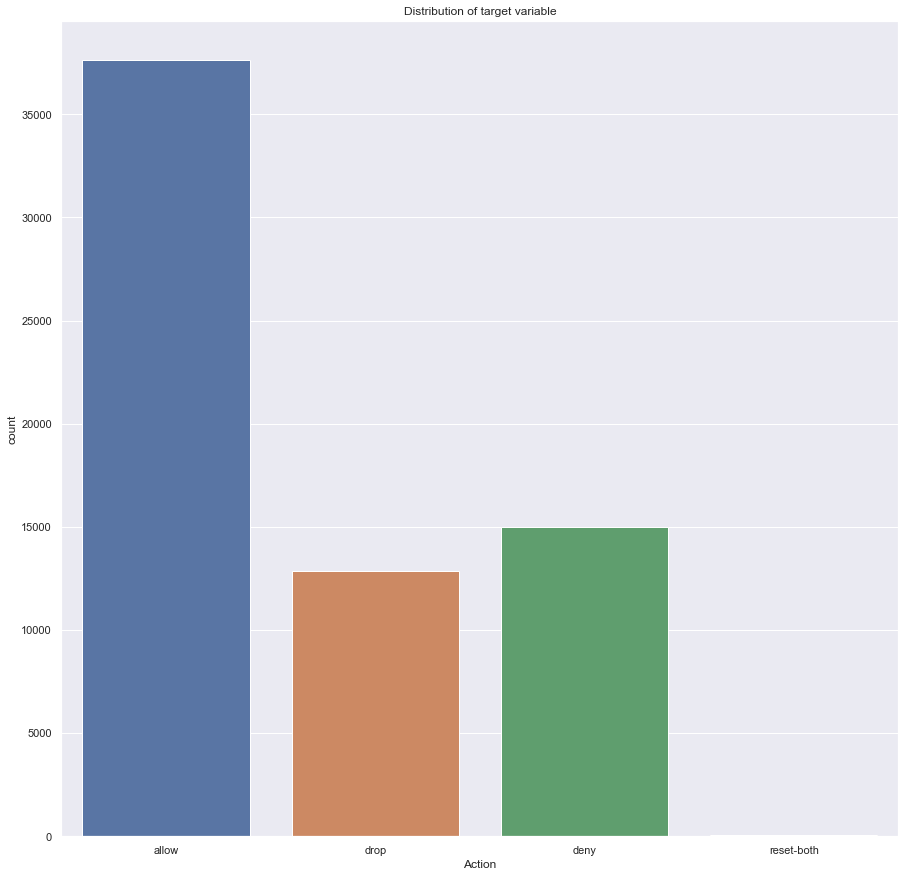

In [8]:
sns.countplot("Action", data = data)
plt.title("Distribution of target variable")

Given that we only have 54 instances of type - reset-both, its better to drop such cases instead of oversampling.

In [9]:
data.drop(data[data.Action == "reset-both"].index, inplace = True)

In [10]:
data.reset_index(inplace = True, drop = True)

C:\Users\Damini Jain\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Elapsed Time (sec)', ylabel='Density'>

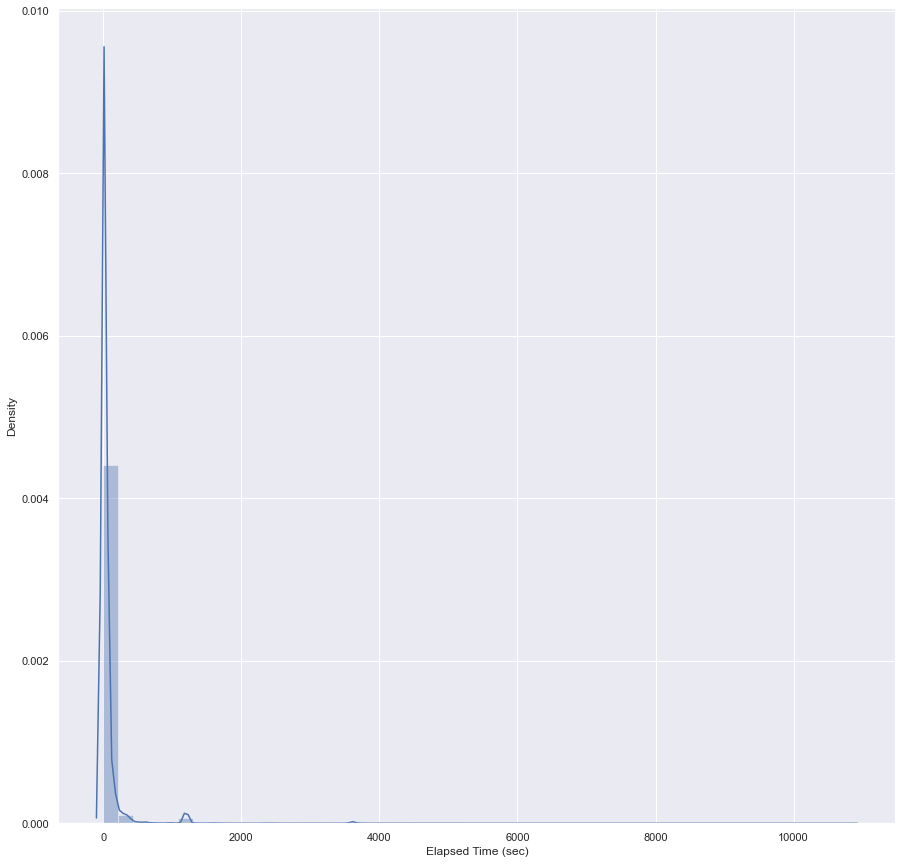

In [11]:
sns.distplot(data["Elapsed Time (sec)"])

The elapsed time distribution is pretty skewed. 

<AxesSubplot:>

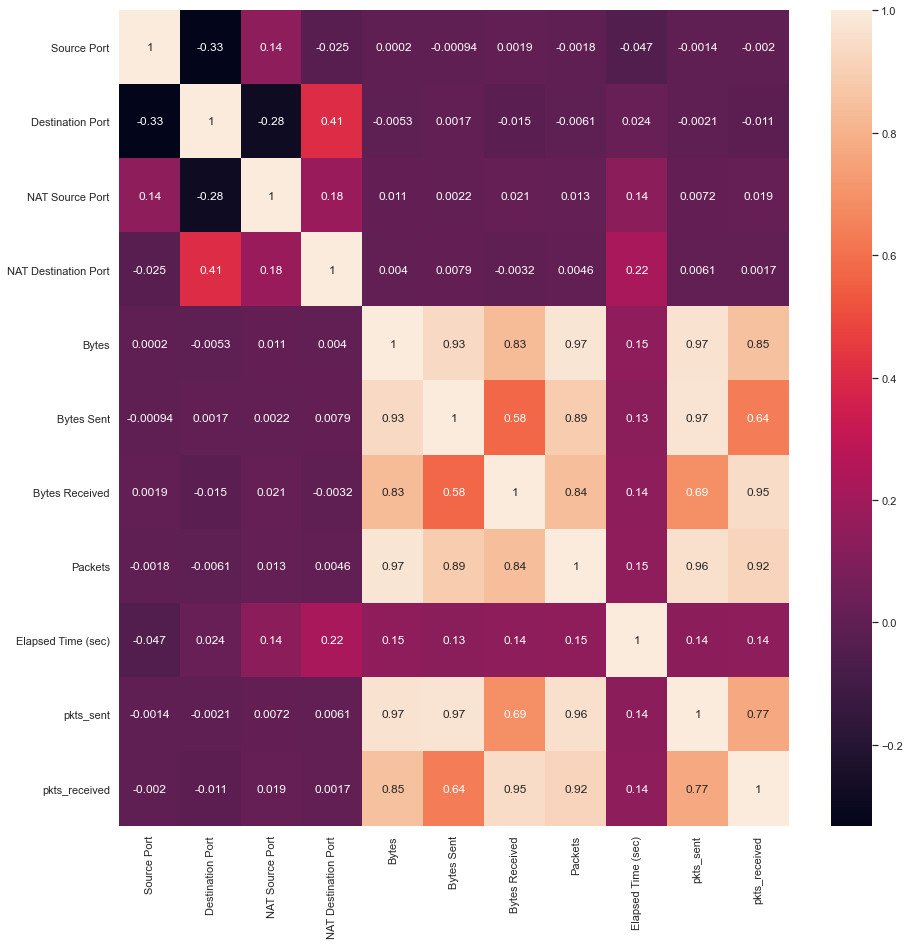

In [12]:
sns.heatmap(data.corr(), annot=True)

In [13]:
# data.Action.unique()

Lets prepare our data for feeding it into the model, by converting the string feature to numerical using LabelEncoder.

In [14]:
le = LabelEncoder()
le.fit(['allow', 'drop', 'deny'])
data["Action"] = pd.Series(le.transform(data["Action"]))
pickle.dump(le, open("labelencoder_action.pkl", "wb"), pickle.HIGHEST_PROTOCOL)

In [15]:
y = data["Action"]

In [16]:
X = data.drop("Action", axis=1)

In [17]:
X.to_csv("X.csv", index = False)
y.to_csv("y.csv", index = False)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state=42, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle = True, test_size = 0.2, random_state=42, stratify = y_train)

In [19]:
### We will use SMOTE to fight imbalance data by generating new samples in the minority classes.

ros = imblearn.over_sampling.RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X_train, y_train)

In [24]:
y_ros.value_counts(normalize = True)

2    0.333333
1    0.333333
0    0.333333
Name: Action, dtype: float64

We have a multiclass classification task in our hand.


Models we are going to try -

Decision Trees, Random Forest, Logistic Regression, XGB, KNN & SVC.

In [25]:
pipeline_dt = Pipeline([("dt_classifier", DecisionTreeClassifier(random_state=42))])
pipeline_rf = Pipeline([("rf_classifier", RandomForestClassifier(random_state=42))])
pipeline_lr = Pipeline([("lr_classifier", LogisticRegression(random_state=42))])
pipeline_xgb = Pipeline([("xgb_classifier", XGBClassifier(random_state=42))])
pipeline_knn = Pipeline([("knn_classifier", KNeighborsClassifier())])
pipeline_svc = Pipeline([("svc_classifier", SVC(random_state=42))])

In [26]:
pipelines = [pipeline_dt, pipeline_rf, pipeline_lr, pipeline_xgb, pipeline_knn, pipeline_svc]

In [27]:
pipe_dict = {0: "Decision Tree", 1:"Random Forest", 2:"Logisitic Regression", 3:"XGBoost", 4:"K Nearest Neighbors", 
             5:"Support Vector Classifer"}

In [28]:
for pipe in pipelines:
    pipe.fit(x_ros, y_ros)

C:\Users\Damini Jain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Damini Jain\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
for i, model in enumerate(pipelines):
    print("{} Validation Accuracy: {}".format(pipe_dict[i], model.score(X_valid, y_valid)))

Decision Tree Validation Accuracy: 0.998377398110146
Random Forest Validation Accuracy: 0.9985682924501289
Logisitic Regression Validation Accuracy: 0.9872100792211511
XGBoost Validation Accuracy: 0.9987591867901117


C:\Users\Damini Jain\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


K Nearest Neighbors Validation Accuracy: 0.9939868282905412
Support Vector Classifer Validation Accuracy: 0.6847379975183736


In [ ]:
data.columns

In [ ]:
for column in data[['Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received']]:
    print("The Skewness of {0} is: {1}".format(column, skew(data[column])))

In [ ]:
### Lets tune parameters for XGBClassifier.

In [30]:
xgb_params = {"learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5], 
              "max_depth": [3, 5, 7],
              "min_child_weight": np.arange(1, 5),
              "subsample": [0.5, 0.7, 0.9],
              "colsample_bytree": [0.5, 0.7, 0.9, 1.0],
              "n_estimators": [500, 1000, 1500, 3000]}

In [34]:
randomgridsearch_xgb = RandomizedSearchCV(estimator = XGBClassifier(objective = "multi:softmax", random_state = 42), 
                              param_distributions = xgb_params, n_jobs = -1, scoring = "roc_auc", 
                                random_state=42)
randomgridsearch_xgb.fit(x_ros, y_ros, eval_set=[(X_valid, y_valid)], early_stopping_rounds = 300)

C:\Users\Damini Jain\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Damini Jain\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09118
[1]	validation_0-mlogloss:1.08380
[2]	validation_0-mlogloss:1.07651
[3]	validation_0-mlogloss:1.06926
[4]	validation_0-mlogloss:1.06210
[5]	validation_0-mlogloss:1.05500
[6]	validation_0-mlogloss:1.04796
[7]	validation_0-mlogloss:1.04100
[8]	validation_0-mlogloss:1.03408
[9]	validation_0-mlogloss:1.02724
[10]	validation_0-mlogloss:1.02044
[11]	validation_0-mlogloss:1.01371
[12]	validation_0-mlogloss:1.00703
[13]	validation_0-mlogloss:1.00043
[14]	validation_0-mlogloss:0.99388
[15]	validation_0-mlogloss:0.98740
[16]	validation_0-mlogloss:0.98095
[17]	validation_0-mlogloss:0.97457
[18]	validation_0-mlogloss:0.96823
[19]	validation_0-mlogloss:0.96196

[222]	validation_0-mlogloss:0.30032
[223]	validation_0-mlogloss:0.29874
[224]	validation_0-mlogloss:0.29716
[225]	validation_0-mlogloss:0.29560
[226]	validation_0-mlogloss:0.29404
[227]	validation_0-mlogloss:0.29250
[228]	validation_0-mlogloss:0.29096
[229]	validation_0-mlogloss:0.28943
[230]	validation_0-mlogloss:0.28791
[231]	validation_0-mlogloss:0.28640
[232]	validation_0-mlogloss:0.28490
[233]	validation_0-mlogloss:0.28340
[234]	validation_0-mlogloss:0.28192
[235]	validation_0-mlogloss:0.28044
[236]	validation_0-mlogloss:0.27897
[237]	validation_0-mlogloss:0.27751
[238]	validation_0-mlogloss:0.27606
[239]	validation_0-mlogloss:0.27461
[240]	validation_0-mlogloss:0.27318
[241]	validation_0-mlogloss:0.27175
[242]	validation_0-mlogloss:0.27033
[243]	validation_0-mlogloss:0.26892
[244]	validation_0-mlogloss:0.26752
[245]	validation_0-mlogloss:0.26613
[246]	validation_0-mlogloss:0.26474
[247]	validation_0-mlogloss:0.26336
[248]	validation_0-mlogloss:0.26199
[249]	validation_0-mlogloss:

[450]	validation_0-mlogloss:0.09551
[451]	validation_0-mlogloss:0.09505
[452]	validation_0-mlogloss:0.09460
[453]	validation_0-mlogloss:0.09415
[454]	validation_0-mlogloss:0.09370
[455]	validation_0-mlogloss:0.09325
[456]	validation_0-mlogloss:0.09281
[457]	validation_0-mlogloss:0.09237
[458]	validation_0-mlogloss:0.09193
[459]	validation_0-mlogloss:0.09149
[460]	validation_0-mlogloss:0.09106
[461]	validation_0-mlogloss:0.09062
[462]	validation_0-mlogloss:0.09020
[463]	validation_0-mlogloss:0.08977
[464]	validation_0-mlogloss:0.08934
[465]	validation_0-mlogloss:0.08892
[466]	validation_0-mlogloss:0.08850
[467]	validation_0-mlogloss:0.08808
[468]	validation_0-mlogloss:0.08766
[469]	validation_0-mlogloss:0.08725
[470]	validation_0-mlogloss:0.08684
[471]	validation_0-mlogloss:0.08643
[472]	validation_0-mlogloss:0.08602
[473]	validation_0-mlogloss:0.08561
[474]	validation_0-mlogloss:0.08521
[475]	validation_0-mlogloss:0.08480
[476]	validation_0-mlogloss:0.08440
[477]	validation_0-mlogloss:

[678]	validation_0-mlogloss:0.03444
[679]	validation_0-mlogloss:0.03430
[680]	validation_0-mlogloss:0.03416
[681]	validation_0-mlogloss:0.03402
[682]	validation_0-mlogloss:0.03389
[683]	validation_0-mlogloss:0.03375
[684]	validation_0-mlogloss:0.03361
[685]	validation_0-mlogloss:0.03347
[686]	validation_0-mlogloss:0.03334
[687]	validation_0-mlogloss:0.03320
[688]	validation_0-mlogloss:0.03307
[689]	validation_0-mlogloss:0.03294
[690]	validation_0-mlogloss:0.03280
[691]	validation_0-mlogloss:0.03267
[692]	validation_0-mlogloss:0.03254
[693]	validation_0-mlogloss:0.03241
[694]	validation_0-mlogloss:0.03228
[695]	validation_0-mlogloss:0.03215
[696]	validation_0-mlogloss:0.03202
[697]	validation_0-mlogloss:0.03189
[698]	validation_0-mlogloss:0.03176
[699]	validation_0-mlogloss:0.03164
[700]	validation_0-mlogloss:0.03151
[701]	validation_0-mlogloss:0.03138
[702]	validation_0-mlogloss:0.03126
[703]	validation_0-mlogloss:0.03113
[704]	validation_0-mlogloss:0.03101
[705]	validation_0-mlogloss:

[906]	validation_0-mlogloss:0.01504
[907]	validation_0-mlogloss:0.01499
[908]	validation_0-mlogloss:0.01495
[909]	validation_0-mlogloss:0.01490
[910]	validation_0-mlogloss:0.01486
[911]	validation_0-mlogloss:0.01481
[912]	validation_0-mlogloss:0.01477
[913]	validation_0-mlogloss:0.01472
[914]	validation_0-mlogloss:0.01468
[915]	validation_0-mlogloss:0.01463
[916]	validation_0-mlogloss:0.01459
[917]	validation_0-mlogloss:0.01454
[918]	validation_0-mlogloss:0.01450
[919]	validation_0-mlogloss:0.01445
[920]	validation_0-mlogloss:0.01441
[921]	validation_0-mlogloss:0.01437
[922]	validation_0-mlogloss:0.01432
[923]	validation_0-mlogloss:0.01428
[924]	validation_0-mlogloss:0.01424
[925]	validation_0-mlogloss:0.01419
[926]	validation_0-mlogloss:0.01415
[927]	validation_0-mlogloss:0.01411
[928]	validation_0-mlogloss:0.01407
[929]	validation_0-mlogloss:0.01403
[930]	validation_0-mlogloss:0.01399
[931]	validation_0-mlogloss:0.01395
[932]	validation_0-mlogloss:0.01391
[933]	validation_0-mlogloss:

[1130]	validation_0-mlogloss:0.00884
[1131]	validation_0-mlogloss:0.00883
[1132]	validation_0-mlogloss:0.00881
[1133]	validation_0-mlogloss:0.00880
[1134]	validation_0-mlogloss:0.00878
[1135]	validation_0-mlogloss:0.00877
[1136]	validation_0-mlogloss:0.00876
[1137]	validation_0-mlogloss:0.00874
[1138]	validation_0-mlogloss:0.00873
[1139]	validation_0-mlogloss:0.00871
[1140]	validation_0-mlogloss:0.00870
[1141]	validation_0-mlogloss:0.00868
[1142]	validation_0-mlogloss:0.00867
[1143]	validation_0-mlogloss:0.00866
[1144]	validation_0-mlogloss:0.00864
[1145]	validation_0-mlogloss:0.00863
[1146]	validation_0-mlogloss:0.00861
[1147]	validation_0-mlogloss:0.00860
[1148]	validation_0-mlogloss:0.00859
[1149]	validation_0-mlogloss:0.00857
[1150]	validation_0-mlogloss:0.00856
[1151]	validation_0-mlogloss:0.00855
[1152]	validation_0-mlogloss:0.00853
[1153]	validation_0-mlogloss:0.00852
[1154]	validation_0-mlogloss:0.00851
[1155]	validation_0-mlogloss:0.00850
[1156]	validation_0-mlogloss:0.00848
[

[1352]	validation_0-mlogloss:0.00684
[1353]	validation_0-mlogloss:0.00683
[1354]	validation_0-mlogloss:0.00683
[1355]	validation_0-mlogloss:0.00682
[1356]	validation_0-mlogloss:0.00682
[1357]	validation_0-mlogloss:0.00681
[1358]	validation_0-mlogloss:0.00681
[1359]	validation_0-mlogloss:0.00680
[1360]	validation_0-mlogloss:0.00680
[1361]	validation_0-mlogloss:0.00679
[1362]	validation_0-mlogloss:0.00679
[1363]	validation_0-mlogloss:0.00678
[1364]	validation_0-mlogloss:0.00678
[1365]	validation_0-mlogloss:0.00677
[1366]	validation_0-mlogloss:0.00677
[1367]	validation_0-mlogloss:0.00676
[1368]	validation_0-mlogloss:0.00676
[1369]	validation_0-mlogloss:0.00675
[1370]	validation_0-mlogloss:0.00675
[1371]	validation_0-mlogloss:0.00674
[1372]	validation_0-mlogloss:0.00674
[1373]	validation_0-mlogloss:0.00673
[1374]	validation_0-mlogloss:0.00673
[1375]	validation_0-mlogloss:0.00672
[1376]	validation_0-mlogloss:0.00672
[1377]	validation_0-mlogloss:0.00671
[1378]	validation_0-mlogloss:0.00671
[

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_param

In [35]:
randomgridsearch_xgb.best_params_

{'subsample': 0.5,
 'n_estimators': 1500,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.005,
 'colsample_bytree': 1.0}

In [39]:
bestxgb_model = XGBClassifier(objective = "multi:softmax", random_state = 42, subsample = 0.5,
 n_estimators = 1500, min_child_weight = 1, max_depth = 3, learning_rate = 0.005, colsample_bytree = 1.0)

In [40]:
bestxgb_model.fit(x_ros, y_ros)

C:\Users\Damini Jain\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
bestxgb_model.classes_

array([0, 1, 2])

In [63]:
type(y_test)

pandas.core.series.Series

In [41]:
bestxgb_pred = bestxgb_model.predict(X_test)

In [45]:
bestxgb_predproba = bestxgb_model.predict_proba(X_test)

In [46]:
roc_auc_score(y_test, bestxgb_predproba, multi_class='ovo', average='weighted').round(2)

1.0

In [49]:
print(classification_report(y_test, bestxgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7528
           1       1.00      1.00      1.00      2998
           2       1.00      1.00      1.00      2570

    accuracy                           1.00     13096
   macro avg       1.00      1.00      1.00     13096
weighted avg       1.00      1.00      1.00     13096



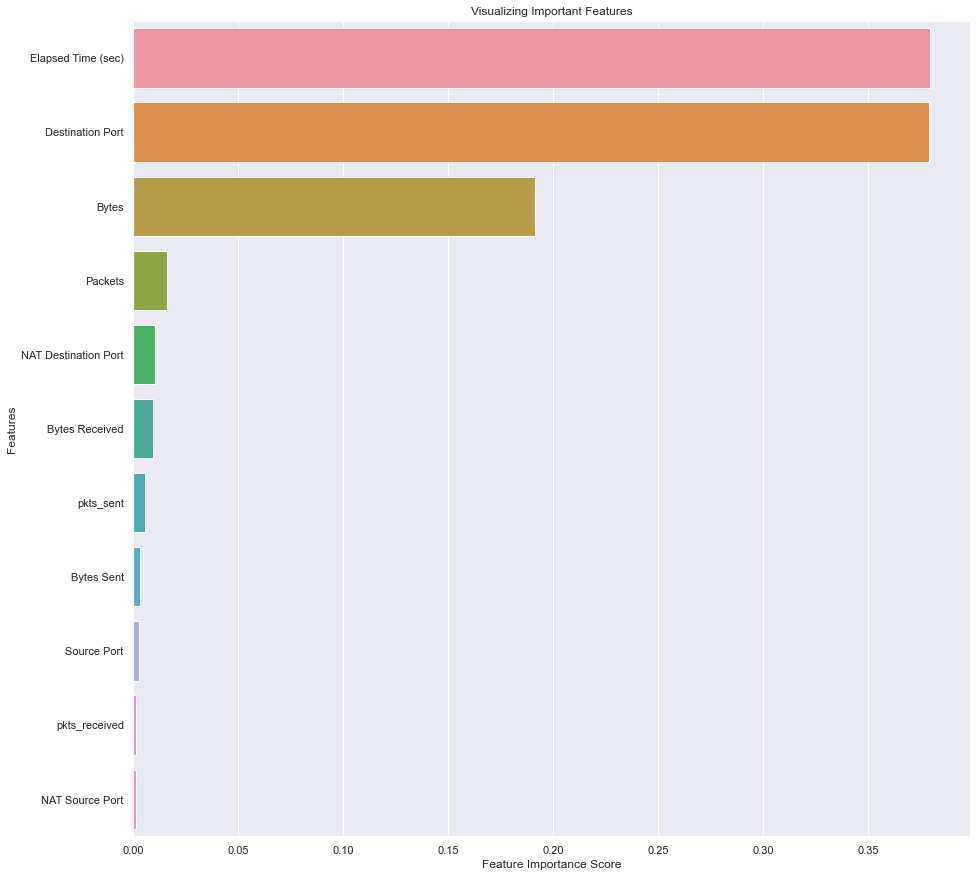

In [53]:
feature_imp = pd.Series(bestxgb_model.feature_importances_ ,index = X.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.show()

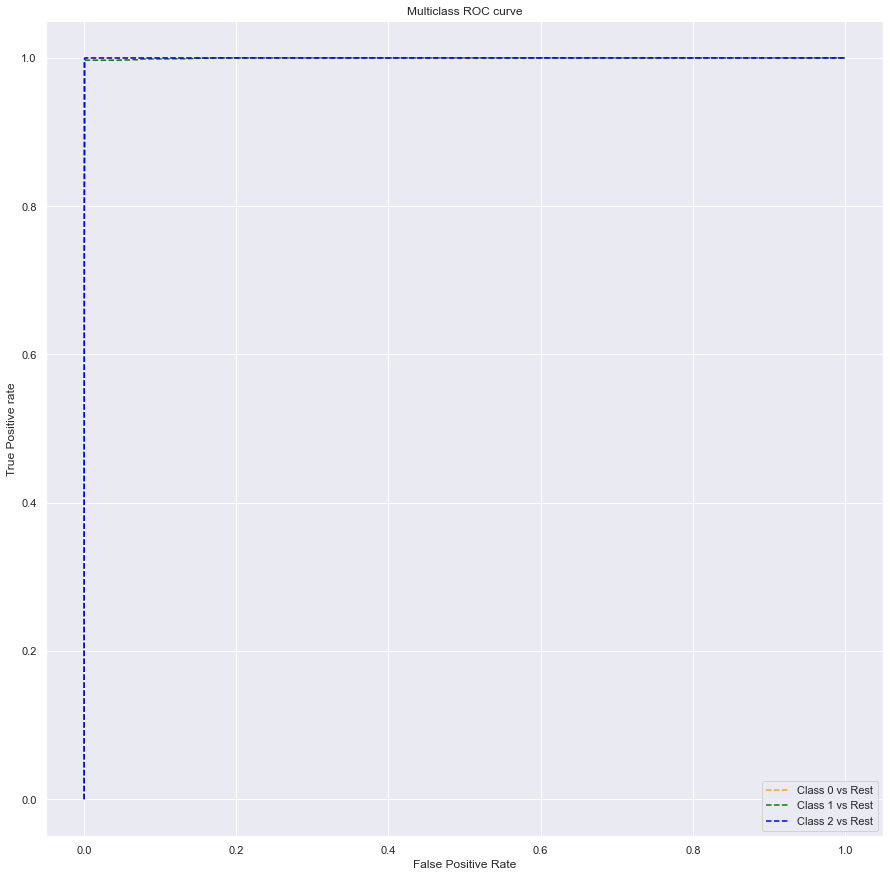

In [54]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, bestxgb_predproba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [61]:
validxgb_predproba = bestxgb_model.predict_proba(X_valid)
xgb_predproba = bestxgb_model.predict_proba(X_test)
print("ROC-AUC score of model on validation set: {0}".format(roc_auc_score(y_valid, validxgb_predproba, multi_class='ovo', average='weighted')))
print("ROC-AUC of model on test set: {0}".format(roc_auc_score(y_test, xgb_predproba, multi_class='ovo', average='weighted')))

ROC-AUC score of model on validation set: 0.9996631179073021
ROC-AUC of model on test set: 0.9997754976707939
